# Predicting Voter Turnout in North Carolina


## Data Sources and Data Acquisition: ##

### Data is sourced from the NC State Board of Elections

### As public documents, voter registration rolls, updated monthly, are available for download via FTP.   ##

### Data retrieved:
- Voting History = 2009 to 2018:  6,349,795 Voters casting 30,631,198 votes across 67 elections.
- Archived Voting History = 2004 to 2013:  6,129,691 Voters casting 28,321,437 votes across 133 elections.
- Combined, initial set totals 59 M votes across 200 elections.
- N.B. 41,020,973 ballots are cast in all generals (federal/statewide = 35,878,239) (local = 5,142,734)
- Total voter registration file totals 7.3 million voters
- Inventory uniques to 28,661,855 ballots cast by 7,327,650 voters (3.9 ballots/voter)




In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc

import os
import time
import sys

- THIS IS THE SOLUTION for creating new columns (x axis) by iterating over rows in pandas dataframe.
- Post processing of this result will rely on mean values for 1/0 vote columns and dedupe via groupby
- Preprocessing -- process and automation to be engineered, as well. 

In [56]:
# LEGACY CODE FROM PREPROCESSING - will iterate  over df, setting vkey as additional x axis and assign int (1/0)
#for x in VHStwUnique.vkey.unique():
#    VHStwUnique[x]=(VHStwUnique.vkey==x).astype(int)
#VHStwUnique.head(100)

In [69]:
dfII = pd.read_csv("dfIIA.dat", sep = '|')
del dfII['Unnamed: 0']
dfII.head()

,ncid,county,gender,age,race,party,rYear,vdex,vmethod,11022004,11072006,11042008,11022010,11062012,11042014,11082016,11062018
0,AA56273,1,F,83,W,UNA,1984,1.0,0.875,1,1,1,1,1,1,1,1
1,AA201627,1,F,40,W,UNA,2018,0.0,0.000,0,0,0,0,0,0,0,0
2,AA98377,1,F,42,W,UNA,1996,1.0,0.500,1,1,1,1,1,1,1,1
3,AA69747,1,F,73,W,UNA,1989,1.0,0.250,1,1,1,1,1,1,1,1
4,AA170513,1,M,70,W,DEM,2012,1.0,0.000,0,0,0,0,1,1,1,1


In [58]:
dfII.loc[dfII.vdex > 1, 'vdex'] = 1
dfII = dfII.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

# Visual Exploration and data prep for modeling

In [ ]:
cat_cols = [
    "gender",
    "race",
    "party",
    "11022004",
    "11072006",
    "11042008",
    "11022010",
    "11062012",
    "11042014",
    "11082016",
    "11062018"
]

In [ ]:
num_cols = [
    "vdex",
    "vmethod",
    "age"
   # "ballots"
]

In [60]:
# check for NaN
for col in cat_cols:
    print(col, len(dfII.loc[dfII[col].isna()]))

gender 0
race 0
party 0


In [61]:
# checkpoint output
dfII.to_csv("dfII.dat", sep = '|', header = True)

In [62]:
# check for NaN
for col in num_cols:
    print(col, len(dfII.loc[dfII[col].isna()]))

vdex 0
vmethod 0
age 0


# VDEX -- Voting Index:
## Synthesized datapoint showing ratio or percentage of the number of votes cast by a registrant vs. the number of elections in which they were eligible to vote.

## N.B -- Voters voting in 75% or more of eligible elections are good for 3.73M votes! This represents a previous standard method of TO prediction.

In [6]:
dfII.vdex.value_counts()

1.000000    2489824
0.000000    1076798
0.500000     892047
0.875000     532268
0.750000     515536
0.625000     344706
0.250000     335291
0.333333     218000
0.375000     206445
0.666667     198359
0.833333     105922
0.125000      69809
0.200000      57216
0.166667      53724
0.400000      46799
0.857143      42282
0.800000      40372
0.600000      40281
0.571429      36471
0.714286      36066
0.428571      35685
0.285714      30601
0.142857      16872
Name: vdex, dtype: int64


### Vdex shows a total of around 49% voting all the time or none of the time!  Also shows an even, declining distribution of voting down the scale. Watch for the value of vdex as a proxy for voting probability going forward.

In [70]:
vdexP = dfII.vdex.value_counts() / len(dfII)

Text(0.5,1,'NC vdex - % of eligible ballots voted')

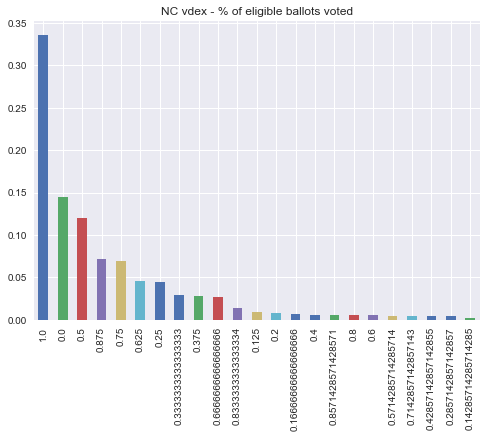

In [71]:
vdexP.plot(kind="bar")
plt.title("NC vdex - % of eligible ballots voted")

# single variable distributions

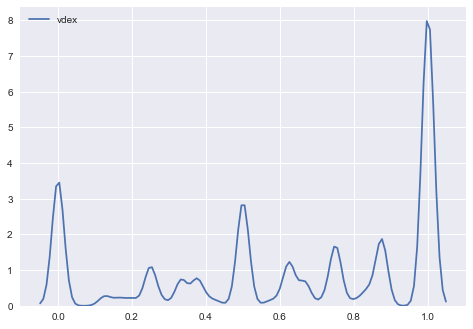

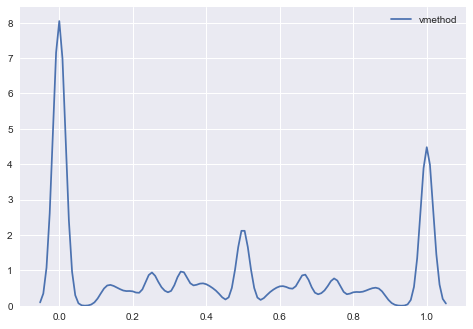

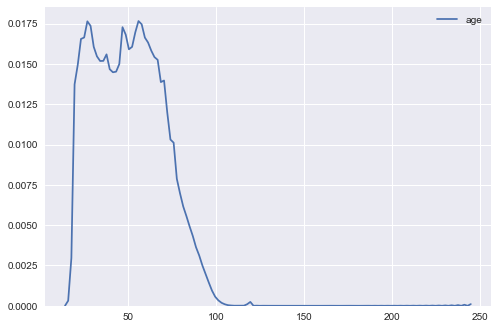

In [65]:
for col in num_cols:
    sns.kdeplot(dfII[col])
    plt.show()

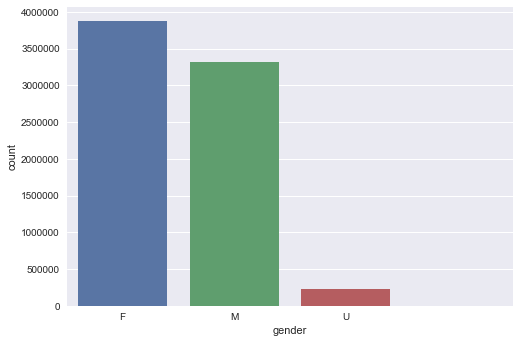

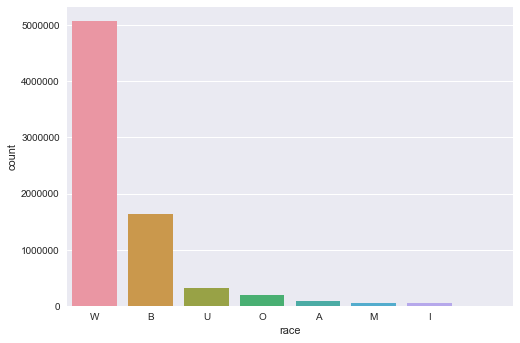

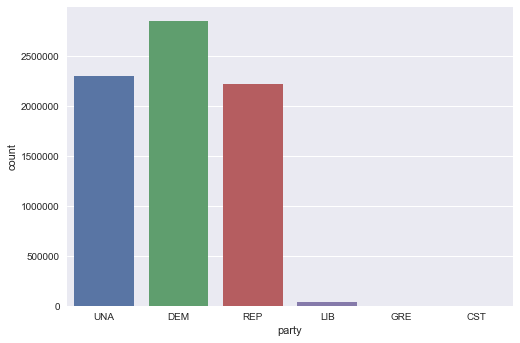

In [66]:

cat_cols = [
    "gender",
    "race",
    "party"
   # "birth_state"
]

for col in cat_cols:
    sns.countplot(col, data=dfII)
    plt.show()

Distributions of gender, race and party registration are consistent with statewide rates for each.  

# Exploring Vdex vs...

In [16]:
plt.style.use("seaborn")

#### This will be a peak at 2018 voting (y_pred) to illustrate the direction of vdex in the prediction

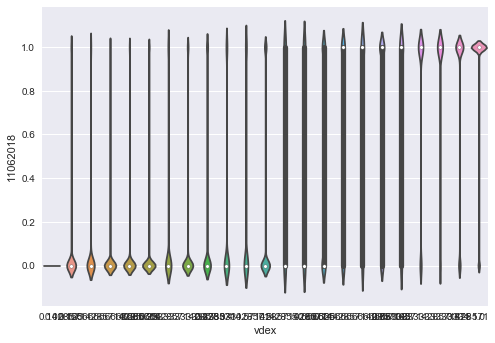

In [18]:
sns.violinplot(x="vdex", y="11062018", data=dfII)

#### In comparisson to holding vdex against a presidential year's voting, showing much broader distribution

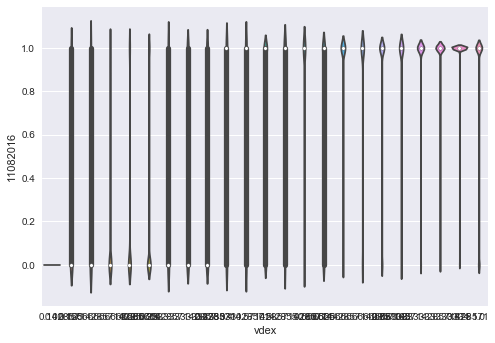

In [19]:
sns.violinplot(x="vdex", y="11082016", data=dfII)

#### Plot below shows distribution of voting method (0 absentee, 1 at polling place as mean score) vs vdex

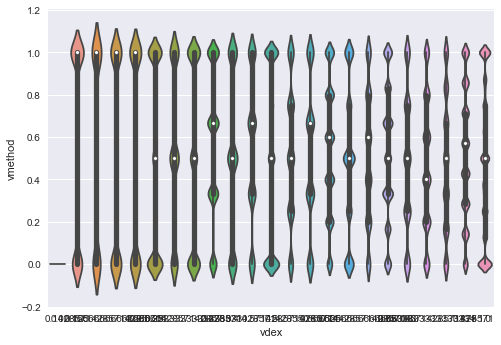

In [20]:
sns.violinplot(x="vdex", y="vmethod", data=dfII)

# Feature Selection/Feature Importance

In [21]:
dfII.columns


Index(['Unnamed: 0', 'ncid', 'county', 'gender', 'age', 'race', 'party',
       'rYear', 'vdex', 'vmethod', '11022004', '11072006', '11042008',
       '11022010', '11062012', '11042014', '11082016', '11062018'],
      dtype='object')

In [25]:
features_to_use = [
    "age",
   "gender",
    "race",
    "party",
    "vdex",
    "vmethod",
    "11022004",
    "11072006",
    "11042008",
    "11022010",
    "11062012",
    "11042014",
    "11082016"
]

In [26]:
X = dfII[features_to_use]

In [27]:
y = dfII[["11062018"]]

In [28]:
X.head()

,age,gender,race,party,vdex,vmethod,11022004,11072006,11042008,11022010,11062012,11042014,11082016
0,83,F,W,UNA,1.0,0.875,1,1,1,1,1,1,1
1,40,F,W,UNA,0.0,0.000,0,0,0,0,0,0,0
2,42,F,W,UNA,1.0,0.500,1,1,1,1,1,1,1
3,73,F,W,UNA,1.0,0.250,1,1,1,1,1,1,1
4,70,M,W,DEM,1.0,0.000,0,0,0,0,1,1,1


In [29]:
X.shape

(7421374, 13)

In [30]:
y.head()

,11062018
0,1
1,0
2,1
3,1
4,1


In [31]:
y.shape

(7421374, 1)

In [32]:
X_encoded = pd.get_dummies(X)

In [33]:

X_encoded.shape

(7421374, 28)

In [34]:
X_encoded.columns

Index(['age', 'vdex', 'vmethod', '11022004', '11072006', '11042008',
       '11022010', '11062012', '11042014', '11082016', 'gender_ ', 'gender_F',
       'gender_M', 'gender_U', 'race_ ', 'race_A', 'race_B', 'race_I',
       'race_M', 'race_O', 'race_U', 'race_W', 'party_CST', 'party_DEM',
       'party_GRE', 'party_LIB', 'party_REP', 'party_UNA'],
      dtype='object')

In [35]:
# inital tests for feature importances

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42)

In [37]:
X_train.shape, X_test.shape

((5566030, 28), (1855344, 28))

In [38]:
y_train.shape, y_test.shape

((5566030, 1), (1855344, 1))

In [39]:
X_train.head()

,age,vdex,vmethod,11022004,11072006,11042008,11022010,11062012,11042014,11082016,...,race_M,race_O,race_U,race_W,party_CST,party_DEM,party_GRE,party_LIB,party_REP,party_UNA
2604972,34,0.857143,0.500000,1,0,1,0,1,1,1,...,0,0,0,1,0,1,0,0,0,0
5595571,24,0.250000,1.000000,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1614815,57,0.750000,0.666667,1,1,1,0,1,0,1,...,0,0,0,1,0,1,0,0,0,0
5454977,47,0.750000,0.666667,0,0,0,0,1,1,1,...,0,1,0,0,0,1,0,0,0,0
2089516,54,1.000000,0.500000,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0


In [40]:
# normalize
sds = StandardScaler()
sds.fit(X_train)
X_train = sds.transform(X_train)
X_test = sds.transform(X_test)

In [41]:
pd.DataFrame(X_train).describe()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
count,5.566030e+06,5.566030e+06,5.566030e+06,5.566030e+06,5.566030e+06,5.566030e+06,5.566030e+06,5.566030e+06,5.566030e+06,5.566030e+06,...,5.566030e+06,5.566030e+06,5.566030e+06,5.566030e+06,5.566030e+06,5.566030e+06,5.566030e+06,5.566030e+06,5.566030e+06,5.566030e+06
mean,6.417852e-16,4.965598e-16,-7.763321e-15,3.452988e-14,2.622272e-14,-5.482231e-15,3.567527e-15,8.188221e-15,2.914956e-14,4.956674e-14,...,1.037591e-14,1.011155e-14,1.417713e-14,-1.279470e-15,1.012450e-14,-3.108036e-15,7.389824e-16,1.184712e-14,1.816654e-15,-5.710496e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.703418e+00,-1.747904e+00,-1.086251e+00,-7.982002e-01,-5.709296e-01,-1.049321e+00,-7.550497e-01,-1.252075e+00,-8.092982e-01,-1.339789e+00,...,-8.250697e-02,-1.625468e-01,-2.127018e-01,-1.470873e+00,-1.127902e-02,-7.901213e-01,-1.190684e-02,-7.272070e-02,-6.540231e-01,-6.711077e-01
25%,-8.797330e-01,-8.226353e-01,-1.086251e+00,-7.982002e-01,-5.709296e-01,-1.049321e+00,-7.550497e-01,-1.252075e+00,-8.092982e-01,-1.339789e+00,...,-8.250697e-02,-1.625468e-01,-2.127018e-01,-1.470873e+00,-1.127902e-02,-7.901213e-01,-1.190684e-02,-7.272070e-02,-6.540231e-01,-6.711077e-01
50%,-4.567692e-03,3.339508e-01,-1.121080e-01,-7.982002e-01,-5.709296e-01,9.529969e-01,-7.550497e-01,7.986741e-01,-8.092982e-01,7.463864e-01,...,-8.250697e-02,-1.625468e-01,-2.127018e-01,6.798683e-01,-1.127902e-02,-7.901213e-01,-1.190684e-02,-7.272070e-02,-6.540231e-01,-6.711077e-01
75%,7.676370e-01,1.027902e+00,8.620347e-01,1.252819e+00,-5.709296e-01,9.529969e-01,1.324416e+00,7.986741e-01,1.235638e+00,7.463864e-01,...,-8.250697e-02,-1.625468e-01,-2.127018e-01,6.798683e-01,-1.127902e-02,1.265628e+00,-1.190684e-02,-7.272070e-02,1.528998e+00,1.490074e+00
max,9.879652e+00,1.027902e+00,1.511463e+00,1.252819e+00,1.751529e+00,9.529969e-01,1.324416e+00,7.986741e-01,1.235638e+00,7.463864e-01,...,1.212019e+01,6.152076e+00,4.701417e+00,6.798683e-01,8.866016e+01,1.265628e+00,8.398534e+01,1.375124e+01,1.528998e+00,1.490074e+00


In [42]:
# double check for null values in X_train (transform fail is negative)
pd.isnull(X_train).sum() > 0

False

In [43]:
pd.DataFrame(X_test).describe()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
count,1.855344e+06,1.855344e+06,1.855344e+06,1.855344e+06,1.855344e+06,1.855344e+06,1.855344e+06,1.855344e+06,1.855344e+06,1.855344e+06,...,1.855344e+06,1.855344e+06,1.855344e+06,1.855344e+06,1.855344e+06,1.855344e+06,1.855344e+06,1.855344e+06,1.855344e+06,1.855344e+06
mean,-9.923192e-04,-2.234289e-03,-9.016703e-04,-2.253962e-03,-1.261569e-03,-1.823894e-03,-1.086698e-03,-5.398462e-04,-1.317772e-03,-2.786030e-03,...,-2.414551e-05,1.470244e-03,-9.226824e-04,-7.331520e-04,4.778840e-05,-4.575249e-04,1.086551e-03,3.427148e-04,3.205880e-04,8.090947e-05
std,1.000162e+00,1.000881e+00,9.997452e-01,9.994853e-01,9.992545e-01,1.000086e+00,9.996903e-01,1.000122e+00,9.997185e-01,1.000823e+00,...,9.998549e-01,1.004393e+00,9.979269e-01,1.000290e+00,1.002116e+00,9.998914e-01,1.044625e+00,1.002341e+00,1.000140e+00,1.000033e+00
min,-1.703418e+00,-1.747904e+00,-1.086251e+00,-7.982002e-01,-5.709296e-01,-1.049321e+00,-7.550497e-01,-1.252075e+00,-8.092982e-01,-1.339789e+00,...,-8.250697e-02,-1.625468e-01,-2.127018e-01,-1.470873e+00,-1.127902e-02,-7.901213e-01,-1.190684e-02,-7.272070e-02,-6.540231e-01,-6.711077e-01
25%,-8.797330e-01,-8.226353e-01,-1.086251e+00,-7.982002e-01,-5.709296e-01,-1.049321e+00,-7.550497e-01,-1.252075e+00,-8.092982e-01,-1.339789e+00,...,-8.250697e-02,-1.625468e-01,-2.127018e-01,-1.470873e+00,-1.127902e-02,-7.901213e-01,-1.190684e-02,-7.272070e-02,-6.540231e-01,-6.711077e-01
50%,-4.567692e-03,3.339508e-01,-1.121080e-01,-7.982002e-01,-5.709296e-01,9.529969e-01,-7.550497e-01,7.986741e-01,-8.092982e-01,7.463864e-01,...,-8.250697e-02,-1.625468e-01,-2.127018e-01,6.798683e-01,-1.127902e-02,-7.901213e-01,-1.190684e-02,-7.272070e-02,-6.540231e-01,-6.711077e-01
75%,7.676370e-01,1.027902e+00,8.620347e-01,1.252819e+00,-5.709296e-01,9.529969e-01,1.324416e+00,7.986741e-01,1.235638e+00,7.463864e-01,...,-8.250697e-02,-1.625468e-01,-2.127018e-01,6.798683e-01,-1.127902e-02,1.265628e+00,-1.190684e-02,-7.272070e-02,1.528998e+00,1.490074e+00
max,4.319778e+00,1.027902e+00,1.511463e+00,1.252819e+00,1.751529e+00,9.529969e-01,1.324416e+00,7.986741e-01,1.235638e+00,7.463864e-01,...,1.212019e+01,6.152076e+00,4.701417e+00,6.798683e-01,8.866016e+01,1.265628e+00,8.398534e+01,1.375124e+01,1.528998e+00,1.490074e+00


In [44]:
# double check for null values in X_test (transform fail is negative)
pd.isnull(X_test).sum() > 0

False

### Deploy DecisionTreeCLF for fitness and a look at feature importance

In [74]:
for i in range(5):
    
    t0 = time.time()
    clf = DecisionTreeClassifier()
    
    clf.fit(X_train, y_train)
    t1 = time.time()
    
    ypred = clf.predict(X_test)
    scores = roc_auc_score(y_test, ypred)
    
    print(f"Decision tree {i+1} took {t1-t0} seconds to train and got a score of {scores}")
    print()
    print("And here are the top features: ")
    c = X_encoded.columns 
    for cfi in zip(c, clf.feature_importances_):
        print(cfi)
    print()
    

Decision tree 1 took 59.956594944000244 seconds to train and got a score of 0.9810259405710167

And here are the top features: 
('age', 0.010939761729221738)
('vdex', 0.6326853727524481)
('vmethod', 0.04082459976048343)
('11022004', 0.0404617037587906)
('11072006', 0.04696699662090047)
('11042008', 0.04893395825147128)
('11022010', 0.04795571732972133)
('11062012', 0.03838186400569024)
('11042014', 0.049710335502922025)
('11082016', 0.037836994213069776)
('gender_ ', 0.0)
('gender_F', 0.0005100021887405917)
('gender_M', 0.0005660787070936294)
('gender_U', 0.0004119427248989469)
('race_ ', 0.0)
('race_A', 0.00014397981483409473)
('race_B', 0.00037777287387004855)
('race_I', 0.00013038178311878843)
('race_M', 0.00011936235063290967)
('race_O', 0.00019271651185548465)
('race_U', 0.00036707799200845416)
('race_W', 0.0005925742023019032)
('party_CST', 1.1813637180637887e-05)
('party_DEM', 0.0005787741084065941)
('party_GRE', 1.093664731468354e-05)
('party_LIB', 0.00013894481204419995)
('par

In [82]:
# save that training clf for future use
clfDT1 = clf
clfDT1

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [75]:
# reestablish features_to_use (no change)
features_to_use =features_to_use = ['age', 'vdex', 'vmethod', '11022004', '11072006', '11042008',
       '11022010', '11062012', '11042014', '11082016', 'gender_ ', 'gender_F',
       'gender_M', 'gender_U', 'race_ ', 'race_A', 'race_B', 'race_I',
       'race_M', 'race_O', 'race_U', 'race_W', 'party_CST', 'party_DEM',
       'party_GRE', 'party_LIB', 'party_REP', 'party_UNA']

In [76]:
ypred.sum()

931881

# Model selection work

In [77]:
X_encoded[features_to_use].shape

(7421374, 28)

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded[features_to_use], y, random_state=42)

In [79]:
pd.concat([X_train, y_train], axis=1).head()

,age,vdex,vmethod,11022004,11072006,11042008,11022010,11062012,11042014,11082016,...,race_O,race_U,race_W,party_CST,party_DEM,party_GRE,party_LIB,party_REP,party_UNA,11062018
2604972,34,0.857143,0.500000,1,0,1,0,1,1,1,...,0,0,1,0,1,0,0,0,0,1
5595571,24,0.250000,1.000000,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
1614815,57,0.750000,0.666667,1,1,1,0,1,0,1,...,0,0,1,0,1,0,0,0,0,1
5454977,47,0.750000,0.666667,0,0,0,0,1,1,1,...,1,0,0,0,1,0,0,0,0,0
2089516,54,1.000000,0.500000,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,1


In [80]:
sds = StandardScaler()
sds.fit(X_train)
X_train = sds.transform(X_train)
X_test = sds.transform(X_test)

In [52]:
# shuffle (3) and split (in .33)
def modelbench(classifier, X_train, Y_train):
    
    rs = ShuffleSplit(n_splits=3, test_size=.33)
    
    rs.get_n_splits(X_train)
    
    Y_train = Y_train.values
    Y_train = Y_train.ravel()

    for train_idx, test_idx in rs.split(X_train):
        ssX_train, ssX_test = X_train[train_idx], X_train[test_idx]
        ssy_train, ssy_test = Y_train[train_idx], Y_train[test_idx]

        t0 = time.time()
        
        clf = classifier
        clf.fit(X=ssX_train, y=ssy_train)

        ypred = clf.predict(ssX_test)

        scores = roc_auc_score(ssy_test, ypred)
    
        t1 = time.time()
    
        print(f"{classifier} \n took {t1-t0} seconds to run and got a score of {scores}")
        print()

## Deploy modelbench method to determine best clf (decisionTree optimized, other method outputs turned off).

In [184]:
modelbench(DecisionTreeClassifier(), X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best') 
 took 44.29458928108215 seconds to run and got a score of 0.9806041145800247

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best') 
 took 43.9325270652771 seconds to run and got a score of 0.9806513309674693

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min

In [ ]:
parameters={'min_samples_split' : range(10,500,20),'max_depth': range(1,20,2)}
clf_tree=tree.DecisionTreeClassifier()
clf=grid_search.GridSearchCV(clf_tree,parameters)
clf.fit(X,Y)

In [39]:
modelbench(LogisticRegression(), X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 
 took 16.90951156616211 seconds to run and got a score of 0.8740731756968857

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 
 took 16.892820596694946 seconds to run and got a score of 0.8741468234878439

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 
 took 16.947702169418335 seconds to run and g

In [40]:
modelbench(RandomForestClassifier(), X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) 
 took 93.25159478187561 seconds to run and got a score of 0.9789721455446788

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) 
 took 95.20538640022278 seconds to run and got a score of 0.978998225489451

R

In [114]:
modelbench(RandomForestClassifier(n_estimators=50), X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) 
 took 457.2282154560089 seconds to run and got a score of 0.9797229049042792

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) 
 took 452.8150165081024 seconds to run and got a score of 0.9798089034040778



In [ ]:
modelbench(RandomForestClassifier(n_estimators=100), X_train, y_train)

In [ ]:
modelbench(SVC(kernel="linear"), X_train, y_train)

In [ ]:
modelbench(SVC(kernel="sigmoid"), X_train, y_train)

### GridSearch Section: Explore optimized parameters for possible RandomForestCLF

In [115]:
params = {
    "max_depth": [2,4,6,8,10],
    "min_samples_split": [5, 9, 19],
    "min_samples_leaf": [2, 5, 10],
    "max_leaf_nodes": [15, 20, 50],
}

In [116]:
grid = GridSearchCV(RandomForestClassifier(n_estimators=10), params, cv=5)

In [117]:
grid

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 4, 6, 8, 10], 'min_samples_split': [5, 9, 19], 'min_samples_leaf': [2, 5, 10], 'max_leaf_nodes': [15, 20, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [ ]:
grid.fit(X_train, y_train.values.ravel())

In [185]:
grid.best_estimator_

NameError: name 'grid' is not defined

In [ ]:
grid.best_params_

In [53]:
n_trees = [10,25,50,75,100,150,200]

train_auc = []
test_auc = []

for i in n_trees:
    clf = RandomForestClassifier(n_estimators=i, random_state=1)
    
    clf.fit(X_train, y_train.values.ravel())
    train_auc.append(roc_auc_score(y_train, clf.predict(X_train)))
    test_auc.append(roc_auc_score(y_test, clf.predict(X_test)))
    
train_auc, test_auc

([0.9864126388517941,
  0.9867228383631695,
  0.9867814504070246,
  0.9867928345680864,
  0.9867937161090053,
  0.986794242550033,
  0.9867940545178184],
 [0.9783625202004248,
  0.9790321302680715,
  0.9792702049852727,
  0.9792942624471522,
  0.9793271741725506,
  0.9793425974921104,
  0.979384143359828])

In [ ]:
n_trees = [10,25,50,75,100,150,200]

train_auc = []
test_auc = []

for i in n_trees:
    clf = RandomForestClassifier(max_depth=10, n_estimators=i, random_state=1)
    
    clf.fit(X_train, y_train.values.ravel())
    train_auc.append(roc_auc_score(y_train, clf.predict(X_train)))
    test_auc.append(roc_auc_score(y_test, clf.predict(X_test)))
    

In [ ]:
train_auc, test_auc

In [ ]:
n_trees = [10,25,50,75,100,150]

train_auc = []
test_auc = []

for i in n_trees:
    clf = RandomForestClassifier(max_depth=10, max_leaf_nodes=20, n_estimators=i, random_state=1)
    
    clf.fit(X_train, y_train.values.ravel())
    train_auc.append(roc_auc_score(y_train, clf.predict(X_train)))
    test_auc.append(roc_auc_score(y_test, clf.predict(X_test)))

train_auc, test_auc

In [ ]:
n_trees = [10,25,50,75,100,150]

train_auc = []
test_auc = []

for i in n_trees:
    clf = RandomForestClassifier(max_depth=10, max_leaf_nodes=20, min_samples_split=9,
                                 n_estimators=i, random_state=1)
    
    clf.fit(X_train, y_train.values.ravel())
    train_auc.append(roc_auc_score(y_train, clf.predict(X_train)))
    test_auc.append(roc_auc_score(y_test, clf.predict(X_test)))

train_auc, test_auc

In [186]:
n_trees = [10,25,50,75,100,150]

train_auc = []
test_auc = []

for i in n_trees:
    clf = RandomForestClassifier(max_depth=10, max_leaf_nodes=20, min_samples_split=9,
                                 n_estimators=i)
    
    clf.fit(X_train, y_train.values.ravel())
    train_auc.append(roc_auc_score(y_train, clf.predict(X_train)))
    test_auc.append(roc_auc_score(y_test, clf.predict(X_test)))

train_auc, test_auc

([0.8724534881332533,
  0.8787715167810763,
  0.8769537147205775,
  0.874857178039196,
  0.8758854296031039,
  0.8747593522820573],
 [0.8718725754804536,
  0.8783656102049608,
  0.8764400830567823,
  0.874431549351685,
  0.8755075373108486,
  0.8743349526122591])

## Prepare visualization of clf results

In [ ]:
train_auc = []
test_auc = []

for i in range(1,30):
    clf = RandomForestClassifier(max_depth=i, max_leaf_nodes=20, min_samples_split=9,
                                 n_estimators=25)
    
    clf.fit(X_train, y_train.values.ravel())
    train_auc.append(roc_auc_score(y_train, clf.predict(X_train)))
    test_auc.append(roc_auc_score(y_test, clf.predict(X_test)))

train_auc, test_auc

plt.plot(range(29), train_auc)
plt.plot(range(29), test_auc)

In [ ]:
train_auc = []
test_auc = []

for i in range(2,100):
    clf = RandomForestClassifier(max_depth=15, max_leaf_nodes=i, min_samples_split=9,
                                 n_estimators=25)
    
    clf.fit(X_train, y_train.values.ravel())
    train_auc.append(roc_auc_score(y_train, clf.predict(X_train)))
    test_auc.append(roc_auc_score(y_test, clf.predict(X_test)))

train_auc, test_auc

plt.plot(range(98), train_auc)
plt.plot(range(98), test_auc)

In [ ]:
train_auc = []
test_auc = []

for i in range(30):
    clf = RandomForestClassifier(max_depth=15, max_leaf_nodes=80, min_samples_split=9,
                                 n_estimators=25)
    
    clf.fit(X_train, y_train.values.ravel())
    train_auc.append(roc_auc_score(y_train, clf.predict(X_train)))
    test_auc.append(roc_auc_score(y_test, clf.predict(X_test)))

train_auc, test_auc

plt.plot(range(30), train_auc)
plt.plot(range(30), test_auc)

## DecisionTreeClassifier provides best results and will be moved to production.

### Model Save and Load###

In [ ]:
# access decision tree clf for save
clf = clfDT1
clf

In [ ]:
from sklearn.externals import joblib

In [ ]:
joblib.dump(clf, "NC_Predict_TO18.model")

In [ ]:
# save scaler (scaling)
joblib.dump(sds, "NC_Predict_TO18_scaler.model")

In [ ]:
# del clf (e.g.) unreversable

In [72]:
clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)